# Supervised learning - Predict Titanic survival using XGBoost
-------------------------------

## Context:
On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

Goal: The goal of this project is to use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. This would be useful to apply to any disasterous situations where we can use machine learning model to predict the likelihood of survial for a random individual.

## About the dataset:
Below are the features included in the Titanic dataset:

* **Survival**: Survival (0 = No, 1 = Yes)
* **Pclass**: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
* **Sex**: Gender	
* **Age**: Age of passenger in years	
* **Sibsp**: Number of siblings/spouses aboard the Titanic	
* **Parch**: Number of parents/children aboard the Titanic	
* **Ticket**: The ticket number	
* **Fare**:	Passenger fare	
* **Cabin**: Cabin number	
* **Embarked**: Port of Embarkation	(C = Cherbourg, Q = Queenstown, S = Southampton)

## Content:
**I. Load the dataset**

**II. Exploratory Data Analysis (EDA)**
    1. Missing data imputation
    2. Bivariate and Multivariate analysis
    3. Feature transformation and Feature engineering
**III. Modeling**

### I. Load the dataset

In [1]:
# Import different libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.express as px
import warnings
import re
import pandas_profiling
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

from statsmodels.tools.eval_measures import mse, rmse

%matplotlib inline
py.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

# Edit pandas display option to show more rows and columns:
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# Load the dataset:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
IDtest = test['PassengerId']

# Print out the shape of the dataset:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [3]:
# Print out the first 5 rows of train set:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


### II. Exploratory Data Analysis
#### 1. Missing data inputation:

In [4]:
# Inspect % of missing value per column on the train set and test set:
train_null = train.isnull().sum()/len(train)
print(train_null[train_null>0])
print('')
test_null = test.isnull().sum()/len(test)
print(test_null[test_null>0])

Age        0.199
Cabin      0.771
Embarked   0.002
dtype: float64

Age     0.206
Fare    0.002
Cabin   0.782
dtype: float64


We can see that both train and test set have missing values. Notice that train set has different features with missing values compared to test set. 'Cabin' has the most missing values for both train and test set. We'll address missing values later below. But first, let's drop a couple of columns that we won't need for our model.

In [5]:
# Drop 'PassengerID' and 'Ticket' as we won't need these variables for our model for now:
def drop_columns(df):
    df.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)

In [6]:
# Drop columns on both train and test data
drop_columns(train)
print(train.shape)

drop_columns(test)
print(test.shape)

(891, 10)
(418, 9)


In [7]:
# Reprint the first 5 rows of train set after dropping columns:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,7.250,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,71.283,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,7.925,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,53.100,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.000,0,0,8.050,NaN,S


In [8]:
# Use pandas-profiling to get a summary of the train data:
pandas_profiling.ProfileReport(train)

After inspecting different variables in the train data, it's time to fill missing values. We'll fill 'Age', 'Embarked', and 'Fare' variables as these are features that are missing in both train and test data. Notice that variable 'Cabin' has different numbers after the cabin type as I assume there are multiple rooms in each cabin. For this model, we will only look at cabin number.

In [9]:
# Fill missing values function:
def fill_na (df):
    df['Age'].fillna(df['Age'].median(), inplace=True) # fill with median value
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True) # fill with mode value
    df['Fare'].fillna(df['Fare'].mode()[0], inplace=True) # fill with mode value

# Transform 'Cabin' variable to only keep the cabin number:
def cabin_transform(df):
    df['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df['Cabin']])

In [10]:
# Fill missing values and transform 'Cabin' variable for both train and test data:
fill_na(train)
cabin_transform(train)

fill_na(test)
cabin_transform(test)

In [11]:
# Double-check to make sure we don't have any missing value left:
train_null = train.isnull().sum()/len(train)
print(train_null[train_null>0])

test_null = test.isnull().sum()/len(test)
print(test_null[train_null>0])

Series([], dtype: float64)
Series([], dtype: float64)


#### 2. Bivariate and Multivariate analysis

In [12]:
# First, let's inspect numerical variables:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,891.000,891.000,891.000
mean,0.384,2.309,29.362,0.523,0.382,32.204
std,0.487,0.836,13.020,1.103,0.806,49.693
min,0.000,1.000,0.420,0.000,0.000,0.000
25%,0.000,2.000,22.000,0.000,0.000,7.910
50%,0.000,3.000,28.000,0.000,0.000,14.454
75%,1.000,3.000,35.000,1.000,0.000,31.000
max,1.000,3.000,80.000,8.000,6.000,512.329


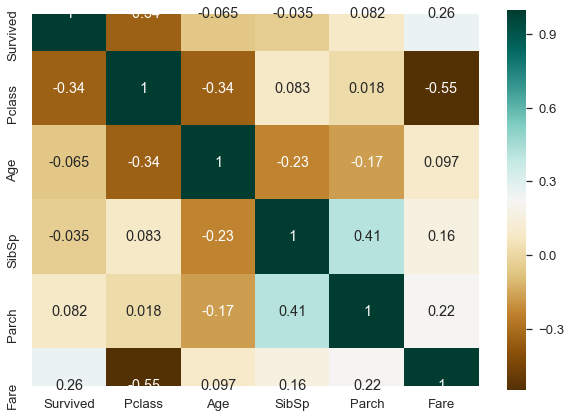

In [13]:
# Plot the correlation matrix
corr = train.corr()

plt.figure(figsize=(10,7))
sns.set(font_scale=1.2)
sns.heatmap(corr, annot=True, cmap='BrBG', square=True)

There are 6 categorical variables included in the train data, including the target variable('Survived'). Looking at the correlation matrix above, we can see that all categorical features have small correlations to one anothe. This is a good thing because we want to avoid multicollinearity(a situation in which two or more explanatory variables in a multiple regression model are highly linearly related, therefore, explain one another). 

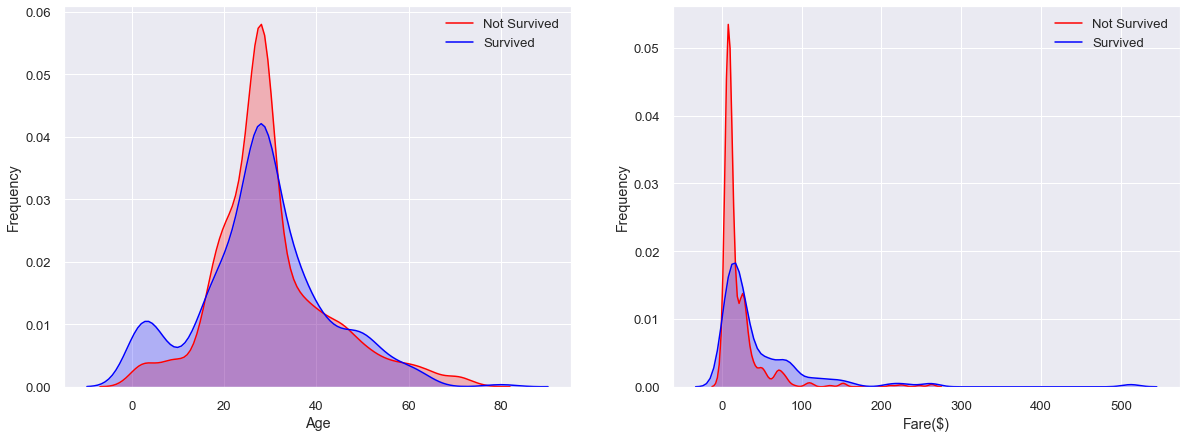

In [14]:
# Let's plot the relationships between age and fare against survival rate:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
sns.kdeplot(train['Age'][train['Survived'] == 0], color='Red', shade = True)
sns.kdeplot(train['Age'][train['Survived'] == 1], color='Blue', shade= True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(['Not Survived','Survived'])

plt.subplot(1,2,2)
sns.kdeplot(train['Fare'][train['Survived'] == 0], color='Red', shade = True)
sns.kdeplot(train['Fare'][train['Survived'] == 1], color='Blue', shade= True)
plt.xlabel('Fare($)')
plt.ylabel('Frequency')
plt.legend(['Not Survived','Survived'])

plt.show()

The 2 charts above shows the relationship between Age and survival rate and between Fare $ amount and survival rate.
* For the first chart, we can see that there's a peak of survival for age between 0 and 3, which makes sense as  small children were prioritize first when the ship got wrecked. Adults around in their 30s died the most as well as furvied more than any other age group.

* For the second chart, it's interesting to observe that the 'low-class' individuals(I assump classes based on the fare amount. My assumption is that wealthier people would be more willing to pay for expensive fares) tends to have lower survival rate. People who paid more thatn $300 in fare are more likely to survive.

Now let's take a look at family size and how that relates to survival

Text(0.5, 1.0, 'Probability of Pclass survival')

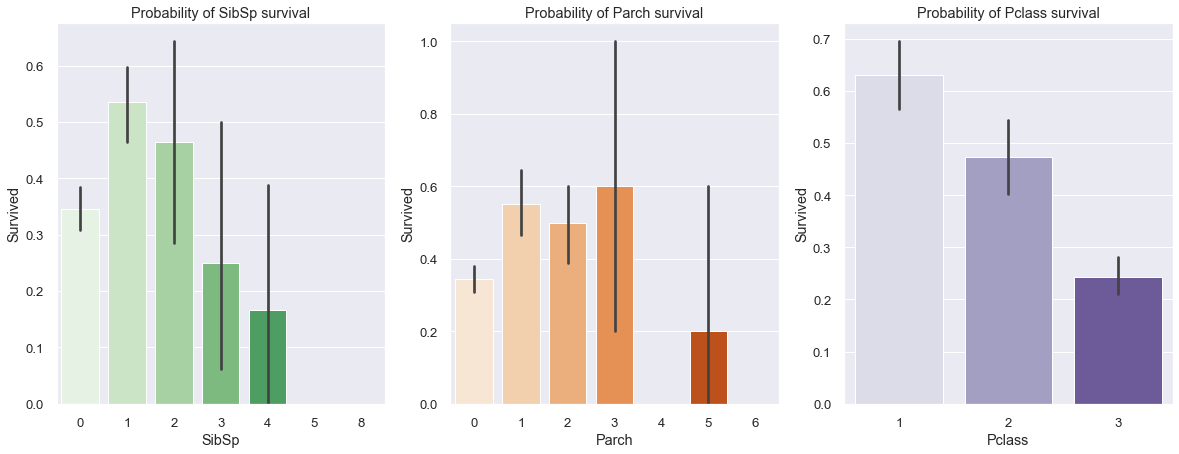

In [15]:
# Plot the relationship between Sibsp and Parch against survival:
plt.figure(figsize=(20,7))

plt.subplot(1,3,1)
sns.barplot(x='SibSp', y='Survived', data=train, palette='Greens')
plt.title('Probability of SibSp survival')

plt.subplot(1,3,2)
sns.barplot(x='Parch', y='Survived', data=train, palette='Oranges')
plt.title('Probability of Parch survival')

plt.subplot(1,3,3)
sns.barplot(x='Pclass', y='Survived', data=train, palette='Purples')
plt.title('Probability of Pclass survival')

The general trend that we can observe is that the more siblings/spouses abroad, the lower chance of survival an individual had. As far as ticket class is concerned, again, the first calss and second class(higher income) had better chance of survival.

In [16]:
# Let's inspect categorical variables:
train.describe(include='object')

,Name,Sex,Cabin,Embarked
count,891,891,891,891
unique,891,2,9,3
top,"Duane, Mr. Frank",male,X,S
freq,1,577,687,646


We have 4 categorical variables in our train dataset: name, gender, cabin type and port of embarkation. Let's inspect them individually.

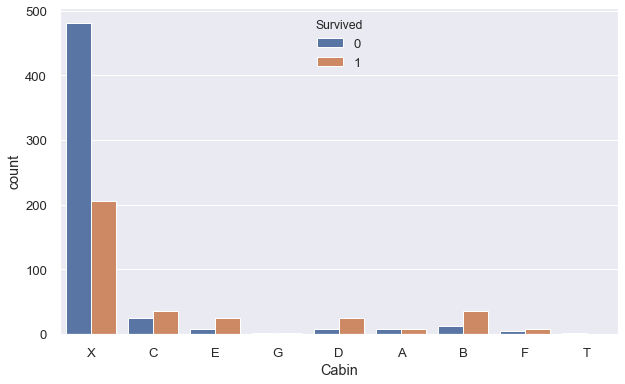

In [17]:
# Let's look at cabin type to see if it has any relationship with survival
plt.figure(figsize=(10,6))
sns.countplot(x='Cabin', hue='Survived', data=train)

Cabin X has the least survivals, however, the majority of travelers stayed in cabin X. Travelers in cabin C, E, D, B and F had more chance of survival.

Text(0.5, 1.0, 'Probability of survival for different gender')

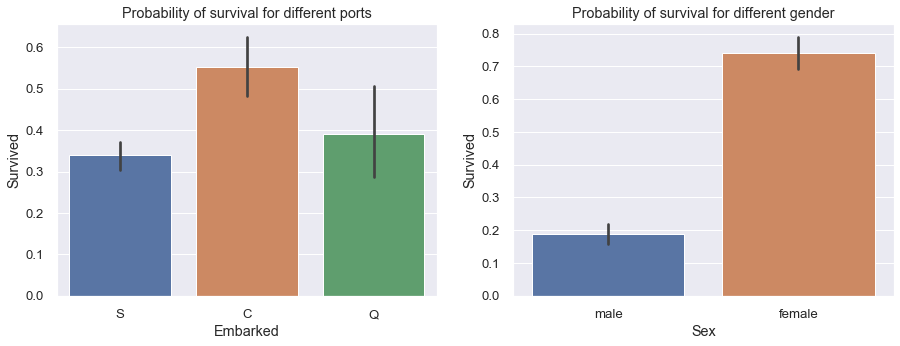

In [18]:
# What about port of embarkation and gender?
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(x='Embarked', y='Survived', data=train)
plt.title('Probability of survival for different ports')

plt.subplot(1,2,2)
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Probability of survival for different gender')

The 2 charts above shows more women survived the ship wreck than men, which is not suprising. Those who ported from Cherbourg also survived more than those ported from other ports.

#### 3. Feature transformation and Feature engineering

In [19]:
# Get titles from names:
def get_title(df):
    df_title = [i.split(',')[1].split('.')[0].strip() for i in df['Name']]
    df['Title'] = pd.Series(df_title)

In [20]:
# Get the titles from train and test set
get_title(train)
get_title(test)

In [21]:
# What titles passengers had?
train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
the Countess      1
Lady              1
Mme               1
Capt              1
Sir               1
Jonkheer          1
Don               1
Ms                1
Name: Title, dtype: int64

In [22]:
# Reduce title:
def reduce_title(df):
    df['Title'] = df['Title'].replace(['the Countess', 'Countess', 'Capt', 'Col', 
                                   'Don', 'Major', 'Rev', 'Sir', 'Jonkheer', 
                                   'Dona', 'Mlle', 'Mme', 'Ms', 'Lady'], 'Other')
    df.drop('Name', axis=1, inplace=True) # Drop 'Name' column as we won't need this anymore

In [23]:
reduce_title(train)
reduce_title(test)

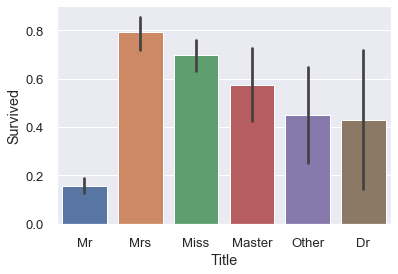

In [24]:
# Plot survival rate by titles:
sns.barplot(x='Title', y='Survived', data=train)

The chart above again agrees with our observation earlier that women had higher rate of survival in the Titanic shipwreck.

In [25]:
# Inspect the first 5 rows of train dataset again after some transformations:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,0,3,male,22.000,1,0,7.250,X,S,Mr
1,1,1,female,38.000,1,0,71.283,C,C,Mrs
2,1,3,female,26.000,0,0,7.925,X,S,Miss
3,1,1,female,35.000,1,0,53.100,C,S,Mrs
4,0,3,male,35.000,0,0,8.050,X,S,Mr


From the data we have, let's create some new features that can potentially improve our model.

In [26]:
# Feature engineering
# Create family size feature:
def family_size(df):
    df['Fsize'] = df['SibSp'] + df['Parch'] + 1
    df['Single'] = df['Fsize'].map(lambda x: 1 if x == 1 else 0) # No family members -> single
    df['SmallF'] = df['Fsize'].map(lambda x: 1 if  x == 2  else 0) # Have 2 family members -> small family
    df['MedF'] = df['Fsize'].map(lambda x: 1 if 3 <= x <= 4 else 0) # Have 3 to 4 members -> medium family
    df['LargeF'] = df['Fsize'].map(lambda x: 1 if x >= 5 else 0)# Have more than 4 members -> large family

In [27]:
# Apply the function to both train and test dataset:
family_size(train)
family_size(test)

In [28]:
# Create has cabin feature:
def has_cabin(df):
    df['HasCabin'] = df['Cabin'].map(lambda x: 1 if x != 'X' else 0) 

# Create wealthy feature
def wealthy(df):
    df['Wealthy'] = df['Pclass'].map(lambda x: 1 if x == 1 else 0)

In [29]:
# Apply has_cabin and wealthy to train and test dataset:
has_cabin(train)
wealthy(train)

has_cabin(test)
wealthy(test)

In [30]:
# Label encoding categorical variables:
def label_encoding(df):
    encoder =LabelEncoder()
    df['Sex'] = encoder.fit_transform(df['Sex'])
    df['Cabin'] = encoder.fit_transform(df['Cabin'])
    df['Embarked'] = encoder.fit_transform(df['Embarked'])
    df['Title'] = encoder.fit_transform(df['Title'])

In [31]:
# Apply label encoder to train and test set:
label_encoding(train)
label_encoding(test)

In [32]:
# Let's take a look at our final train and test data after feature transformation and feature engineering:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Fsize,Single,SmallF,MedF,LargeF,HasCabin,Wealthy
0,0,3,1,22.000,1,0,7.250,8,2,3,2,0,1,0,0,0,0
1,1,1,0,38.000,1,0,71.283,2,0,4,2,0,1,0,0,1,1
2,1,3,0,26.000,0,0,7.925,8,2,2,1,1,0,0,0,0,0
3,1,1,0,35.000,1,0,53.100,2,2,4,2,0,1,0,0,1,1
4,0,3,1,35.000,0,0,8.050,8,2,3,1,1,0,0,0,0,0


In [33]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Fsize,Single,SmallF,MedF,LargeF,HasCabin,Wealthy
0,3,1,34.500,0,0,7.829,7,1,3,1,1,0,0,0,0,0
1,3,0,47.000,1,0,7.000,7,2,4,2,0,1,0,0,0,0
2,2,1,62.000,0,0,9.688,7,1,3,1,1,0,0,0,0,0
3,3,1,27.000,0,0,8.662,7,2,3,1,1,0,0,0,0,0
4,3,0,22.000,1,1,12.287,7,2,4,3,0,0,1,0,0,0


### III. Modeling

In [34]:
# Split train data into explanatory variables and target variable:
X = train.iloc[:,1: ] # explanatory variables
y = train['Survived'] # target variable

In [35]:
print(X.shape)
print(y.shape)
print(test.shape)

(891, 16)
(891,)
(418, 16)


In [36]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Fsize,Single,SmallF,MedF,LargeF,HasCabin,Wealthy
0,3,1,22.000,1,0,7.250,8,2,3,2,0,1,0,0,0,0
1,1,0,38.000,1,0,71.283,2,0,4,2,0,1,0,0,1,1
2,3,0,26.000,0,0,7.925,8,2,2,1,1,0,0,0,0,0
3,1,0,35.000,1,0,53.100,2,2,4,2,0,1,0,0,1,1
4,3,1,35.000,0,0,8.050,8,2,3,1,1,0,0,0,0,0


In [37]:
# Scaling train and test data using StandardScaler:
scaler= StandardScaler()

X = scaler.fit_transform(X)
test = scaler.fit_transform(test)

In [38]:
# Trainsform train data to format that supports xgboost:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [39]:
# Split X and y to train and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [40]:
# Create xgboost classifier model:
model = xgb.XGBClassifier()

In [41]:
both_scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'Loss':'neg_log_loss'}
params = {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth':[3, 4, 5]
        }

In [42]:
# Cross validation to find the best parameters:
clf = GridSearchCV(model, params, cv=5, scoring=both_scoring, refit='AUC', return_train_score=True)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300, 400, 500]},

In [43]:
# Print out the best parameters for our xgb model:
print((clf.best_score_, clf.best_params_))
print('-'*30)

print('Grid scores on training data:')
means = clf.cv_results_['mean_test_AUC']
stds = clf.cv_results_['std_test_AUC']
log_losses = clf.cv_results_['std_test_Loss']

for mean, std, log_loss, params in zip(means, stds, log_losses, clf.cv_results_['params']):
    print('AUC Score: %0.3f (+/-%0.03f); Log Loss: %0.3f for %r' % (mean, std * 2, log_loss, params))

(0.8531709956709956, {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100})
------------------------------
Grid scores on training data:
AUC Score: 0.853 (+/-0.068); Log Loss: 0.034 for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
AUC Score: 0.852 (+/-0.062); Log Loss: 0.044 for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
AUC Score: 0.849 (+/-0.060); Log Loss: 0.049 for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
AUC Score: 0.848 (+/-0.053); Log Loss: 0.050 for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400}
AUC Score: 0.847 (+/-0.052); Log Loss: 0.053 for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
AUC Score: 0.847 (+/-0.060); Log Loss: 0.036 for {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
AUC Score: 0.844 (+/-0.059); Log Loss: 0.045 for {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}
AUC Score: 0.843 (+/-0.050); Log Loss: 0.047 for {'learning_rate': 0.05, 'max_depth': 

In [44]:
# Make predictions 
y_preds = clf.predict(X_test)

In [45]:
print('rmse of testing: {}'.format(rmse(y_preds, y_test)))
print('Accuracy score: {}'.format(accuracy_score(y_preds, y_test)))

rmse of testing: 0.36616691861841205
Accuracy score: 0.8659217877094972


In [46]:
# Make predictions for submission:
predictions = clf.predict(test).astype(int)

In [47]:
# Create submission file to submit:
submission = pd.DataFrame({'PassengerId':IDtest, 'Survived':predictions})

In [48]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [49]:
# Fill submission csv file
filename = 'submit.csv'
submission.to_csv(filename,index=False)